[MNIST](http://yann.lecun.com/exdb/mnist/) para que nossa rede seja capaz de gerar dígitos escritos artificiais.

In [4]:
import tensorflow as tf
import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
#Fazer Gan na mao

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt


image, label = tfds.as_numpy(tfds.load(
    'mnist',
    split='train', 
    batch_size=-1, 
    as_supervised=True,
))
print(type(label),label)
print(type(image), image.shape)
plt.imshow(image[0,:,:,0],cmap="gray")
plt.figure()
plt.imshow(image[1,:,:,0],cmap="gray")
plt.figure()
plt.imshow(image[2,:,:,0],cmap="gray")
plt.figure()
plt.imshow(image[3,:,:,0],cmap="gray")
plt.figure()
plt.imshow(image[4,:,:,0],cmap="gray")
plt.figure()
train_image = image
train_labels = label

In [ ]:
image, label = tfds.as_numpy(tfds.load(
    'mnist',
    split='test', 
    batch_size=-1, 
    as_supervised=True,
))

print(type(image), image.shape)
plt.imshow(image[0,:,:,0],cmap="gray")
plt.figure()
plt.imshow(image[1,:,:,0],cmap="gray")
plt.figure()
plt.imshow(image[2,:,:,0],cmap="gray")
plt.figure()
plt.imshow(image[3,:,:,0],cmap="gray")
plt.figure()
plt.imshow(image[4,:,:,0],cmap="gray")
plt.figure()
test_image = image

In [ ]:
train_dataset = (train_image.reshape((len(train_image),28,28))) / 255.
test_dataset = (test_image.reshape((len(test_image),28,28))) / 255.

In [ ]:
plt.imshow(train_dataset[0,:,:],cmap="gray")
plt.figure()
plt.imshow(test_dataset[1,:,:],cmap="gray")
plt.figure()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, Conv2D, BatchNormalization,Reshape, Activation, Dense, Flatten, MaxPooling2D

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten

embedding_dim = 16
def _batch_norm(inputs, is_training):
  return tf.layers.batch_normalization(
      inputs, momentum=0.999, epsilon=0.001, training=is_training)

#Generator
def unconditional_generator(noise,  weight_decay=2.5e-5):
    """Generator to produce unconditional MNIST images."""
    model = Sequential()
    model.add(Dense(input_dim=64, units=512))
    model.add(Activation('relu'))
    
    model.add(Dense(64*7*7))
    model.add(BatchNormalization())
    
    model.add(Activation('relu'))
    model.add(Reshape((7, 7, 64), input_shape=(64*7*7,))) # 7x7 image
    
    model.add(UpSampling2D(size=(2, 2))) # 14x14 image
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(Activation('relu'))
    
    model.add(UpSampling2D(size=(2, 2))) # 28x28 image
    model.add(Conv2D(1, (5, 5), padding='same'))
    model.add(Activation('relu'))
    
    
    return model

def unconditional_discriminator(img, unused_conditioning, weight_decay=2.5e-5):
    model = Sequential()
    
    model.add(Conv2D(32,(5, 5),padding='same',input_shape=(28, 28, 1)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (5, 5)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    model.add(Flatten())
    
    model.add(Dense(512))
    
    model.add(Activation('relu'))
    
    model.add(Dense(1))
 
    return model

#Discriminator

In [ ]:
generator_lr = 0.001 #@param
discriminator_lr = 0.0002 #@param

def gen_opt():
  gstep = tf.train.get_or_create_global_step()
  base_lr = generator_lr
  # Halve the learning rate at 1000 steps.
  lr = tf.cond(gstep < 1000, lambda: base_lr, lambda: base_lr / 2.0)
  return tf.keras.optimizers.Adam(lr)

In [ ]:
import tensorflow_gan as tfgan
import tensorflow as tf
gan_estimator = tfgan.estimator.GANEstimator(     
        generator_fn=unconditional_generator,
        discriminator_fn=unconditional_discriminator,        
        generator_loss_fn=tfgan.losses.modified_generator_loss,
        discriminator_loss_fn=tfgan.losses.modified_discriminator_loss,        
        generator_optimizer=tf.keras.optimizers.Adam(0.0002, 0.5),
        discriminator_optimizer=tf.keras.optimizers.Adam(0.0002, 0.5),
        add_summaries=tfgan.estimator.SummaryType.IMAGES)

In [ ]:
#Here
def input_fn():
    return tf.convert_to_tensor(train_dataset)

import time
steps_per_eval = 500 #@param
max_train_steps = 5000 #@param
batches_for_eval_metrics = 100 #@param

# Used to track metrics.
steps = []
real_logits, fake_logits = [], []
real_mnist_scores, mnist_scores, frechet_distances = [], [], []

cur_step = 0
start_time = time.time()
while cur_step < max_train_steps:
  next_step = min(cur_step + steps_per_eval, max_train_steps)

  start = time.time()
  gan_estimator.train(input_fn, max_steps=next_step)
  steps_taken = next_step - cur_step
  time_taken = time.time() - start
  print('Time since start: %.2f min' % ((time.time() - start_time) / 60.0))
  print('Trained from step %i to %i in %.2f steps / sec' % (
      cur_step, next_step, steps_taken / time_taken))
  cur_step = next_step
  
  # Calculate some metrics.
  metrics = gan_estimator.evaluate(input_fn, steps=batches_for_eval_metrics)
  steps.append(cur_step)
  real_logits.append(metrics['real_data_logits'])
  fake_logits.append(metrics['gen_data_logits'])
  real_mnist_scores.append(metrics['real_mnist_score'])
  mnist_scores.append(metrics['mnist_score'])
  frechet_distances.append(metrics['frechet_distance'])
  print('Average discriminator output on Real: %.2f  Fake: %.2f' % (
      real_logits[-1], fake_logits[-1]))
  print('Inception Score: %.2f / %.2f  Frechet Distance: %.2f' % (
      mnist_scores[-1], real_mnist_scores[-1], frechet_distances[-1]))
  
  # Vizualize some images.
  iterator = gan_estimator.predict(
      input_fn, hooks=[tf.train.StopAtStepHook(num_steps=21)])
  try:
    imgs = np.array([next(iterator) for _ in range(20)])
  except StopIteration:
    pass
  tiled = tfgan.eval.python_image_grid(imgs, grid_shape=(2, 10))
  plt.axis('off')
  plt.imshow(np.squeeze(tiled))
  plt.show()
  
  
# Plot the metrics vs step.
plt.title('MNIST Frechet distance per step')
plt.plot(steps, frechet_distances)
plt.figure()
plt.title('MNIST Score per step')
plt.plot(steps, mnist_scores)
plt.plot(steps, real_mnist_scores)
plt.show()

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop

def generator_cost_function(y_actual, y_predicted):
        n_examples = y_actual.shape[0]
        #batch = tf.convert_to_tensor(np.zeros((n_examples*2, 28, 28, 1)), dtype=tf.float32)
        batch = tf.concat([y_actual, y_predicted], axis=0)
        #batch[n_examples:, :, :, 0] = y_predicted
        #Designa labels inversas para calcular a loss(o gerador tenta fazer o discriminador errar)
        labels = np.zeros(batch.shape[0])
        labels[n_examples:] = 1. #1 é a label dos exemplos reais para o discriminador e para os falsos no gerador
        prediction = gan_discriminator.predict(batch)
        bce = tf.keras.losses.BinaryCrossentropy(tf.convert_to_tensor(labels),prediction)
        return bce
    
    

dim_random_vector = 64
gan_generator = gan_generator_model(dim_random_vector)
gan_generator.compile(optimizer=Adam(0.0002), loss=generator_cost_function, metrics=['accuracy'])
gan_generator.summary()

gan_discriminator = gan_discriminator_model()
gan_discriminator.compile(optimizer=Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
gan_discriminator.summary()

In [ ]:
batch_size = 64
repet = 1000
epochs = 100


for i in range(repet):
       
    
    gan_generator.fit(np.random.rand(len(train_dataset),dim_random_vector),train_dataset, epochs = epochs,  verbose=2)
    
    batch = np.zeros((len(train_dataset)*2,28,28,1))
    batch[:len(train_dataset), :, :, :] =train_dataset
    batch[len(train_dataset):, :, :, :] = gan_generator.predict(np.random.rand(len(train_dataset),dim_random_vector))
    labels = np.zeros(len(train_dataset)*2)
    labels[:len(train_dataset)] = 1.
    gan_discriminator.fit(batch, labels, epochs= epochs, verbose=2)


In [ ]:
def gan_generator_model(dim_random):
    model = Sequential()
    model.add(Dense(units=512, input_dim=dim_random, activation='relu'))
    model.add(Activation('relu'))
    
    model.add(Dense(64*7*7))
    model.add(BatchNormalization())
    
    model.add(Activation('relu'))
    model.add(Reshape((7, 7, 64), input_shape=(64*7*7,))) # 7x7 image
    
    model.add(UpSampling2D(size=(2, 2))) # 14x14 image
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(Activation('relu'))
    
    model.add(UpSampling2D(size=(2, 2))) # 28x28 image
    model.add(Conv2D(1, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    #model.add(Dense(28*28))
    #model.add(Reshape((28, 28, 1)))
    #model.add(Activation('relu'))
    return model

def gan_discriminator_model():
    model = Sequential()
    model.add(Conv2D(32,(5, 5),padding='same',input_shape=(28, 28, 1)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (5, 5)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    
    #model.add(Activation('relu'))
    
    model.add(Dense(1, activation='sigmoid'))
 
    return model

def define_gan(generator, discriminator):
    # connect generator and discriminator
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model


generator = gan_generator_model(dim_random_vector)
generator.summary()
discriminator = gan_discriminator_model()
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
discriminator.summary()
gan = define_gan(generator, discriminator)
gan.summary()

In [ ]:
train_dataset = train_dataset.reshape((len(train_dataset),28,28,1))
batch_size = 512
half_batch = int(batch_size/2)
epochs = 10000

errors_discrim = np.zeros((epochs))
errors_generator = np.zeros((epochs))

plt.ion()
# manually enumerate epochs
for i in range(epochs):
    batch = np.zeros((batch_size, 28, 28, 1))
    batch_y = np.zeros(batch_size)
    # prepare real samples
    random_indices = np.random.choice(len(train_dataset), size=half_batch, replace=False)
    batch[:half_batch, :, :, :] = train_dataset[random_indices, :, :,:]
    #Label for the real samples is 0, so no need to change batch_y

    batch[half_batch:, :, :] = generator.predict(np.random.rand(half_batch, dim_random_vector))
    batch_y[half_batch:] += 1.
    
    if i%1000 == 0:
        print_images(batch[-25:])
        
   
        
    
   
    errors_discrim[i],_ = discriminator.train_on_batch(batch, batch_y)
    # create inverted labels for the fake samples
    x_gan = np.random.rand(batch_size, dim_random_vector)
    y_gan = np.zeros((batch_size)) + 1.
    # update the generator via the discriminator's error
    errors_generator[i] = gan.train_on_batch(x_gan, y_gan)

In [ ]:
plt.scatter(range(len(errors_discrim)),errors_discrim)
plt.scatter(range(len(errors_generator)),errors_generator)
plt.figure()

generated = generator.predict(np.random.rand(50, dim_random_vector))
plt.imshow(generated[0,:,:].reshape(28,28),cmap="gray")
plt.figure()
plt.imshow(generated[1,:,:].reshape(28,28),cmap="gray")
plt.figure()

print(sum(discriminator.predict(generated)))
print(sum(discriminator.predict(train_dataset[:50, :, :, :])))

In [ ]:
def print_images(samples):
    plt.close()
    for i in range(25):
        # define subplot
        plt.subplot(5, 5, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(samples[i].reshape((28,28)), cmap='gray_r')
    plt.show()
    
print_images(batch)
generated = generator.predict(np.random.rand(50, dim_random_vector))
print(batch[0])

In [5]:
#Aqui
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose, LeakyReLU, Dropout, Input
from tensorflow.keras.layers import UpSampling2D, Conv2D, BatchNormalization,Reshape, Activation, Dense, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras import initializers

import numpy as np

In [6]:
image, label = tfds.as_numpy(tfds.load(
    'mnist',
    split='train', 
    batch_size=-1, 
    as_supervised=True,
))
train_image = image
train_labels = label
image, label = tfds.as_numpy(tfds.load(
    'mnist',
    split='test', 
    batch_size=-1, 
    as_supervised=True,
))

test_image = image
test_labels = label

train_dataset = (train_image.reshape((len(train_image),28,28))-127.5)/127.5
test_dataset = (test_image.reshape((len(test_image),28,28))-127.5)/127.5
train_dataset = train_dataset.reshape((len(train_dataset),28,28,1))
test_dataset = test_dataset.reshape((len(test_dataset),28,28,1))

dim_random_vector = 100

In [7]:
def print_images(samples):
    plt.close()
    for i in range(25):
        # define subplot
        plt.subplot(5, 5, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(samples[i].reshape((28,28)), cmap='gray_r')
    plt.show()
    

def gan_generator_model(dim_random):
    model = Sequential()
    if True:
        model.add(Dense(256, input_dim=dim_random, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        model.add(LeakyReLU(0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1024))
        model.add(LeakyReLU(0.2))
        model.add(Dense(28*28, activation='tanh'))
        model.add(Reshape((28,28,1)))
    else:
        model.add(Dense(128*7*7, input_dim=dim_random, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        model.add(LeakyReLU(0.2))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D(size=(2, 2)))
        model.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
        model.add(LeakyReLU(0.2))
        model.add(UpSampling2D(size=(2, 2)))
        model.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))

    return model


def gan_discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28,28,1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
 
    return model

def define_gan(generator, discriminator):
    # connect generator and discriminator
    discriminator.trainable = False
    ganInput = Input(shape=(dim_random_vector,))
    x = generator(ganInput)
    ganOutput = discriminator(x)
    gan = Model(inputs=ganInput, outputs=ganOutput)
    opt = Adam(lr=0.0002, beta_1=0.5)
    gan.compile(loss='binary_crossentropy', optimizer=opt)
    return gan


generator = gan_generator_model(dim_random_vector)
generator.summary()
discriminator = gan_discriminator_model()
opt = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()
gan = define_gan(generator, discriminator)
gan.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0

In [ ]:
batch_size = 128
half_batch = int(batch_size/2)
epochs = 5000

test_size = 200
half_test = int(test_size /2)

errors_discrim = np.zeros((epochs))
errors_generator = np.zeros((epochs))
perc_discrim = np.zeros((epochs))

plt.ion()
# manually enumerate epochs
for i in range(epochs):
    batch = np.zeros((batch_size, 28, 28, 1))
    batch_y = np.zeros(batch_size)
    # prepare real samples
    random_indices = np.random.choice(len(train_dataset), size=half_batch, replace=False)
    batch[:half_batch, :, :, :] = train_dataset[random_indices, :, :,:]
    #Label for the real samples is 0, so no need to change batch_y

    batch[half_batch:, :, :] = generator.predict(np.random.normal(0, 1, size=[half_batch, dim_random_vector]))
    batch_y[half_batch:] += 0.9 
   
        
    
    discriminator.trainable = True
    errors_discrim[i],_ = discriminator.train_on_batch(batch, batch_y)
    # create inverted labels for the fake samples
    x_gan = np.random.normal(0, 1, size=[batch_size, dim_random_vector])
    y_gan = np.zeros((batch_size)) 
    discriminator.trainable = False
    # update the generator via the discriminator's error
    errors_generator[i] = gan.train_on_batch(x_gan, y_gan)
    
    test_batch = np.zeros((test_size, 28, 28, 1))
    test_y     = np.zeros(test_size)
    test_y[half_test:] += 1.
    random_indices = np.random.choice(len(test_dataset), size=half_test, replace=False)

    test_batch[:half_test, :, :, :] = test_dataset[random_indices, :, :]
    test_batch[half_test:, :, :] = generator.predict(np.random.normal(0, 1, size=[half_test, dim_random_vector]))
    predictions =  (discriminator.predict(test_batch).ravel() > 0.5) * 1.
    
    perc_discrim[i] = sum(predictions == test_y)/test_size
    
    if i%100 == 0:
        print("epoch: "+str(i))
        print_images(generator.predict(np.random.normal(0, 1, size=[25, dim_random_vector])))
        print("Errors Discrimin: " + str(errors_generator[i]))
        print("Errors Generator:" + str(errors_discrim[i]))
        print("Perc Discrim:" + str(perc_discrim[i]))

In [ ]:
plt.plot(errors_discrim)

plt.plot(errors_generator)

plt.figure()
plt.plot(perc_discrim)

In [ ]:
rnd = np.random.normal(0,1, size=[2, dim_random_vector])
samples = generator.predict(rnd)
plt.imshow(samples[0].reshape((28,28)), cmap='gray_r')
plt.figure()
plt.imshow(samples[1].reshape((28,28)), cmap='gray_r')
print(rnd)

In [ ]:
input_dim= 5
def real_function(x):
    return np.multiply(x,x)

def generate_samples(n_samples):
    result = np.zeros((n_samples,2))
    max_x,min_x = -1,+1
    x = (np.random.rand(n_samples)*(max_x-min_x)) + min_x
    result[:,0] = x
    result[:,1] = real_function(x)
    return result
def generator_predict(n_samples, input_dim, generator):
    rnd = np.random.normal(0, 1, size=[n_samples, input_dim])
    return generator.predict(rnd)

train_dataset = generate_samples(10000)
test_dataset = generate_samples(10000)

In [ ]:
def print_images(input_v):
    plt.close()
    x = input_v[:,0]
    y = input_v[:,1]
    plt.scatter(x,y)
    plt.show()
def gan_generator_model(input_dim):
    model = Sequential()
    model.add(Dense(50, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Dense(32))
    model.add(LeakyReLU(0.2))
    model.add(Dense(2, activation='tanh'))
    return model


def gan_discriminator_model():
    model = Sequential()
    model.add(Dense(64, input_dim=2, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
 
    return model

def define_gan(generator, discriminator):
    # connect generator and discriminator
    discriminator.trainable = False
    ganInput = Input(shape=(input_dim,))
    x = generator(ganInput)
    ganOutput = discriminator(x)
    gan = Model(inputs=ganInput, outputs=ganOutput)
    opt = Adam(lr=0.0002, beta_1=0.5)
    gan.compile(loss='binary_crossentropy', optimizer=opt)
    return gan


generator = gan_generator_model(input_dim)
generator.summary()
discriminator = gan_discriminator_model()
opt = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()
gan = define_gan(generator, discriminator)
gan.summary()

In [ ]:
batch_size = 32
half_batch = int(batch_size/2)
epochs = 10000

test_size = 64
half_test = int(test_size /2)

errors_discrim = np.zeros((epochs))
errors_generator = np.zeros((epochs))
perc_discrim = np.zeros((epochs))

plt.ion()
# manually enumerate epochs
for i in range(epochs):
    batch = np.zeros((batch_size, 2))
    batch_y = np.zeros(batch_size)
   
    # prepare real samples
    random_indices = np.random.choice(len(train_dataset), size=half_batch, replace=False)
    batch[:half_batch, :] = train_dataset[random_indices, :]
    #Label for the real samples is 0, so no need to change batch_y

    batch[half_batch:, :] = generator.predict(np.random.normal(0, 1, size=[half_batch, input_dim]))
    batch_y[half_batch:] += 0.9 
   
        
    
    discriminator.trainable = True
    errors_discrim[i],_ = discriminator.train_on_batch(batch, batch_y)
    # create inverted labels for the fake samples
    x_gan = np.random.normal(0, 1, size=[batch_size, input_dim])
    y_gan = np.zeros((batch_size)) 
    discriminator.trainable = False
    # update the generator via the discriminator's error
    errors_generator[i] = gan.train_on_batch(x_gan, y_gan)
    
    test_batch = np.zeros((test_size, 2))
    test_y     = np.zeros(test_size)
    test_y[half_test:] += 1.
    
    random_indices = np.random.choice(len(test_dataset), size=half_test, replace=False)

    test_batch[:half_test, :] = test_dataset[random_indices, :]
    test_batch[half_test:, :] = generator.predict(np.random.normal(0, 1, size=[half_test, input_dim]))
    predictions =  (discriminator.predict(test_batch).ravel() > 0.5) * 1.
    
    perc_discrim[i] = sum(predictions == test_y)/test_size
    
    if i%1000 == 0:
        print("epoch: "+str(i))
        print_images(generator.predict(np.random.normal(0, 1, size=[50, input_dim])))
        print("Errors Discrimin: " + str(errors_generator[i]))
        print("Errors Generator:" + str(errors_discrim[i]))
        print("Perc Discrim:" + str(perc_discrim[i]))

In [ ]:
plt.plot(errors_discrim)

plt.plot(errors_generator)

plt.figure()
plt.plot(perc_discrim)

In [ ]:
gen = generator.predict(np.random.normal(0, 1, size=[1000, input_dim]))
real = generate_samples(10000)

plt.scatter(gen[:,0],gen[:,1])
plt.scatter(real[:,0], real[:,1])

In [ ]:
#AQUIIII

In [11]:
image, label = tfds.as_numpy(tfds.load(
    'mnist',
    split='train', 
    batch_size=-1, 
    as_supervised=True,
))
train_image = image
train_labels = label
image, label = tfds.as_numpy(tfds.load(
    'mnist',
    split='test', 
    batch_size=-1, 
    as_supervised=True,
))

test_image = image
test_labels = label

train_dataset = (train_image.reshape((len(train_image),28,28))-127.5)/127.5
test_dataset = (test_image.reshape((len(test_image),28,28))-127.5)/127.5
train_dataset = train_dataset.reshape((len(train_dataset),28,28,1))
test_dataset = test_dataset.reshape((len(test_dataset),28,28,1))

def print_images(samples):
    plt.close()
    for i in range(25):
        # define subplot
        plt.subplot(5, 5, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(samples[i].reshape((28,28)), cmap='gray_r')
    plt.show()

dim_random_vector = 100

In [16]:
def gan_generator_model(dim_random):
    model = Sequential()
    if False:
        model.add(Dense(256, input_dim=dim_random, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        model.add(LeakyReLU(0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1024))
        model.add(LeakyReLU(0.2))
        model.add(Dense(28*28, activation='tanh'))
        model.add(Reshape((28,28,1)))
    else:
        model.add(Dense(128*7*7, input_dim=dim_random, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.4))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D(size=(2, 2)))
        model.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.4))
        model.add(UpSampling2D(size=(2, 2)))
        model.add(Conv2D(1, kernel_size=(5, 5), padding='same'))
        model.add(Flatten())
        model.add(Dense(28*28, activation='tanh'))
        model.add(Reshape((28,28,1)))

    return model


def gan_discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28,28,1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
 
    return model

def define_gan(generator, discriminator):
    # connect generator and discriminator
    discriminator.trainable = False
    ganInput = Input(shape=(dim_random_vector,))
    x = generator(ganInput)
    ganOutput = discriminator(x)
    gan = Model(inputs=ganInput, outputs=ganOutput)
    opt = Adam(lr=0.0002, beta_1=0.5)
    gan.compile(loss='binary_crossentropy', optimizer=opt)
    return gan


generator = gan_generator_model(dim_random_vector)
generator.summary()
discriminator = gan_discriminator_model()
opt = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()
gan = define_gan(generator, discriminator)
gan.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 6272)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 14, 14, 64)       

In [14]:
def generate_batch_discriminator(batch_size, treino = True):
    half_batch = int(batch_size/2)
    
    batch = np.zeros((batch_size, 28, 28, 1))
    batch_y = np.zeros(batch_size)
    
    #Pega exemplos aleatoriamente da base de treinamento ou teste
    if treino:
        random_indices = np.random.choice(len(train_dataset), size=half_batch, replace=False)
        batch[:half_batch, :, :, :] = train_dataset[random_indices, :, :, ]
    else:
        random_indices = np.random.choice(len(test_dataset), size=half_batch, replace=False)
        batch[:half_batch, :, :, :] = test_dataset[random_indices, :, :, :]
    #Labels das instâncias reais já são 0, entao nao há necessidade de mudar batch_y
    
    # A variável aleatória de entrada do gerador vai seguir uma distribuição normal
    batch[half_batch:, :] = generator.predict(np.random.normal(0, 1, size=[half_batch, dim_random_vector]))
    batch_y[half_batch:] += 1. 
    return batch, batch_y

def generate_batch_gan(batch_size):
    x_gan = np.random.normal(0, 1, size=[batch_size, dim_random_vector])
    #Neste caso criamos labels invertidos para os exemplos falsos, porque a funcao de custo
    # do gerador é o inverso do discriminador
    y_gan = np.zeros((batch_size)) 
    return x_gan,y_gan

epoch: 0


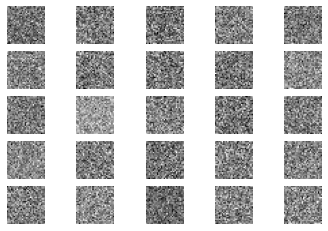

Errors Discrimin: 0.7001951932907104
Errors Generator:0.6928281188011169
Perc Discrim:0.56
epoch: 1000


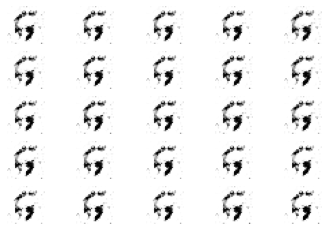

Errors Discrimin: 0.15557634830474854
Errors Generator:2.855133533477783
Perc Discrim:0.47
epoch: 2000


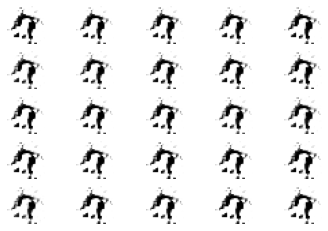

Errors Discrimin: 0.036528196185827255
Errors Generator:4.582909107208252
Perc Discrim:0.98
epoch: 3000


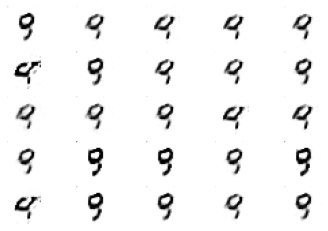

Errors Discrimin: 0.2749113142490387
Errors Generator:2.883112907409668
Perc Discrim:0.95
epoch: 4000


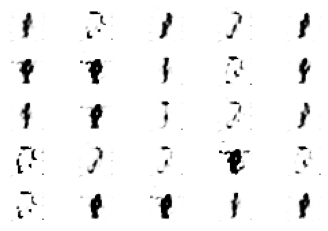

Errors Discrimin: 0.1948307454586029
Errors Generator:2.464125156402588
Perc Discrim:0.95
epoch: 5000


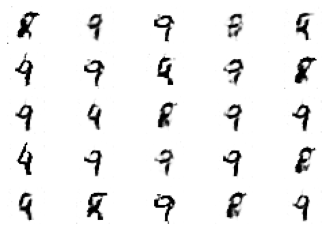

Errors Discrimin: 0.25214138627052307
Errors Generator:4.322271347045898
Perc Discrim:0.94
epoch: 6000


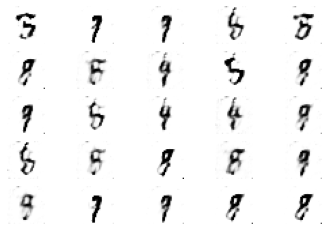

Errors Discrimin: 0.19874098896980286
Errors Generator:3.0610036849975586
Perc Discrim:0.98
epoch: 7000


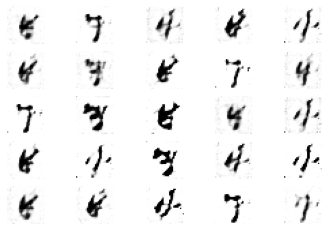

Errors Discrimin: 0.3007014989852905
Errors Generator:3.942429780960083
Perc Discrim:0.9
epoch: 8000


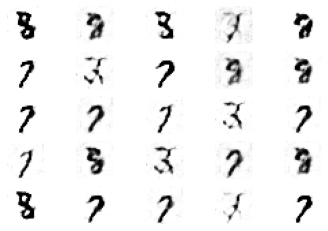

Errors Discrimin: 0.1897803544998169
Errors Generator:3.3949337005615234
Perc Discrim:0.92
epoch: 9000


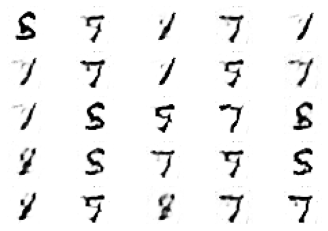

Errors Discrimin: 0.28112101554870605
Errors Generator:4.045943737030029
Perc Discrim:0.91
epoch: 10000


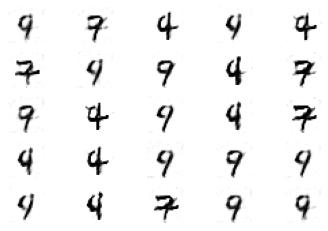

Errors Discrimin: 0.25213080644607544
Errors Generator:3.33829665184021
Perc Discrim:0.96
epoch: 11000


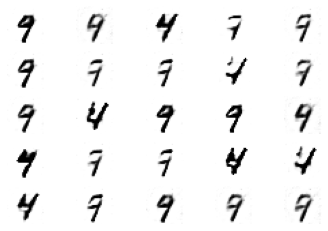

Errors Discrimin: 0.24686509370803833
Errors Generator:3.2884926795959473
Perc Discrim:0.92
epoch: 12000


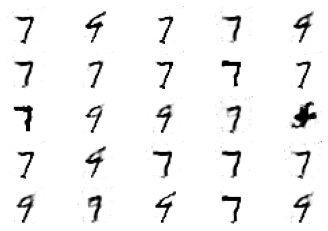

Errors Discrimin: 0.14650359749794006
Errors Generator:3.4815545082092285
Perc Discrim:0.93
epoch: 13000


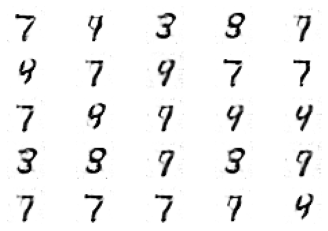

Errors Discrimin: 0.2612416744232178
Errors Generator:2.889069080352783
Perc Discrim:0.93
epoch: 14000


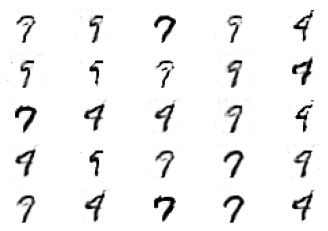

Errors Discrimin: 0.12073983252048492
Errors Generator:3.978695869445801
Perc Discrim:0.95
epoch: 15000


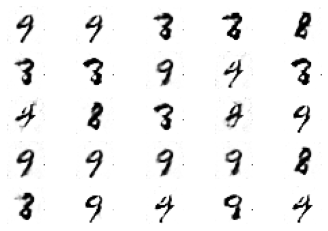

Errors Discrimin: 0.29258498549461365
Errors Generator:3.1861391067504883
Perc Discrim:0.95
epoch: 16000


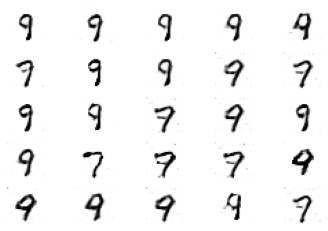

Errors Discrimin: 0.15160301327705383
Errors Generator:3.686194896697998
Perc Discrim:0.94
epoch: 17000


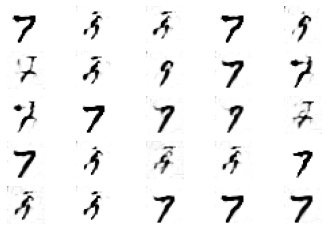

Errors Discrimin: 0.09731103479862213
Errors Generator:3.6392910480499268
Perc Discrim:0.95
epoch: 18000


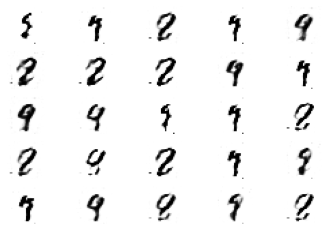

Errors Discrimin: 0.24673695862293243
Errors Generator:3.405460834503174
Perc Discrim:0.95
epoch: 19000


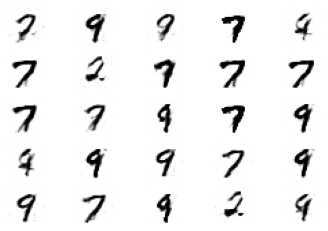

Errors Discrimin: 0.22853250801563263
Errors Generator:3.528872489929199
Perc Discrim:0.94


In [17]:
batch_size = 128
epochs = 20000

test_size = 100
half_test = int(test_size /2)

#Erros do discriminador e gerador, e percentual de acerto no teste
errors_discrim = np.zeros((epochs))
errors_generator = np.zeros((epochs))
perc_discrim = np.zeros((epochs))

#Utilizado para a visualização de imagens não travar o treinamento
plt.ion()

for i in range(epochs):
    
    batch,batch_y = generate_batch_discriminator(batch_size, treino=True)       
    #Preparando o discriminador para ter seus pesos atualizados
    discriminator.trainable = True
    errors_discrim[i],_ = discriminator.train_on_batch(batch, batch_y)
    
    
    x_gan, y_gan = generate_batch_gan(batch_size)
    discriminator.trainable = False
    # update the generator via the discriminator's error
    errors_generator[i] = gan.train_on_batch(x_gan, y_gan)
    
    #Gera um batch de teste e calcula a acuracia do discriminador
    test_batch,test_y = generate_batch_discriminator(test_size, treino=False) 
   
    predictions =  (discriminator.predict(test_batch).ravel() > 0.5) * 1.
    
    perc_discrim[i] = sum(predictions == test_y)/test_size
    #periodicamente
    if i%1000 == 0:
        print("epoch: "+str(i))
        print_images(generator.predict(np.random.normal(0, 1, size=[50, dim_random_vector])))
        print("Errors Discrimin: " + str(errors_discrim[i]))
        print("Errors Generator:" + str(errors_generator[i]))
        print("Perc Discrim:" + str(perc_discrim[i]))

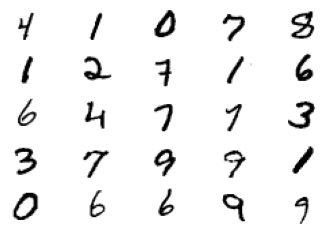

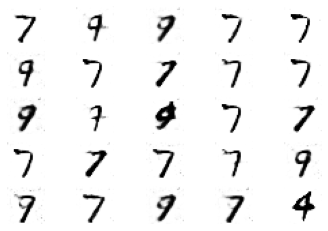

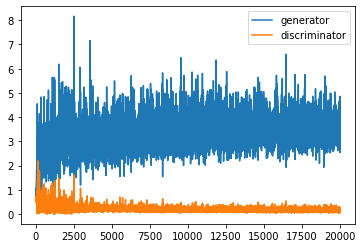

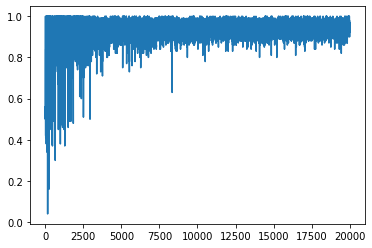

In [19]:
print_images(train_dataset[:100,:])
print_images(generator.predict(np.random.normal(0, 1, size=[100, dim_random_vector])))

plt.plot(errors_generator, label='generator')
plt.plot(errors_discrim, label='discriminator')
plt.legend()

plt.figure()
plt.plot(perc_discrim)